# Домашняя работа 9. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline


In [18]:
df = pd.read_csv('../data/winequality-red.csv.gz', compression='gzip', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


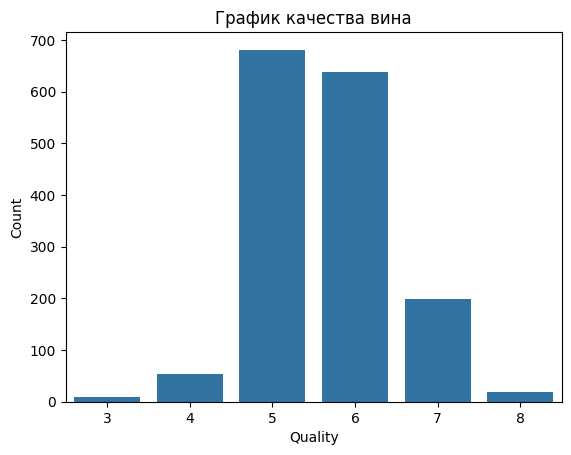

In [19]:
sns.countplot(x='quality', data=df)
plt.title('График качества вина')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

- Что вы думаете по поводу количества представителей каждого класса.  
Ответ: не совсем понятно, является ли качество количеством баллов на каком-нибудь сайте или чем-то иным. Тем не менее график напоминает нормальное распределение

In [20]:
X = df.drop('quality', axis=1)
y = df['quality']

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Выведем модели подряд
models = {
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=10),
    'KNeighborsClassifier with Scaling': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10)),
    'RidgeClassifier': RidgeClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'BaggingClassifier': BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42),
    'BaggingClassifier with Random Features': BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, max_features=0.5, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    print(f'{name}: {np.mean(scores):.4f}')

KNeighborsClassifier: 0.5122
KNeighborsClassifier with Scaling: 0.5816
RidgeClassifier: 0.5835
DecisionTreeClassifier: 0.6179
BaggingClassifier: 0.6980
BaggingClassifier with Random Features: 0.6948
RandomForestClassifier: 0.7017


Вывод: лучшая модель - RandomForestClassifier.

### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

1) KNeighborsClassifier расстояние для классификации, и на его работу сильно влияет шкала признаков. Если признаки имеют разные масштабы, это может привести к преобладанию одних признаков над другими. Если один из признаков измеряется в тысячах, а другой — в долях, то модель будет больше опираться на тот, который имеет больший диапазон значений.  Масштабирование StandardScaler приводит все признаки к одному масштабу, что позволяет модели работать эффективно и корректнее учитывать все признаки

2) Деревья решений строятся, разделяя пространство признаков на подпространства с использованием пороговых значений признаков. Модели деревьев решений не зависят от масштаба данных, потому что они ориентируются на относительные значения признаков, а не на абсолютные. Даже если признаки имеют различные масштабы, дерево решений всё равно будет искать пороги, которые разделяют классы, на основе их относительных значений

3) В BaggingClassifier каждый классификатор обучается на случайном подмножестве данных, что помогает моделям стать менее чувствительными к шуму. Когда используется ограничение на количество признаков для каждого дерева, это, наверное, может привести к созданию более разнообразных деревьев. Каждое дерево становится более независимым и фокусируется на меньшем количестве признаков, что предотвращает переобучение на одном признаке

In [22]:
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    std_score = np.std(scores)
    print(f'{name}: Standard Deviation = {std_score:.4f}')

KNeighborsClassifier: Standard Deviation = 0.0265
KNeighborsClassifier with Scaling: Standard Deviation = 0.0192
RidgeClassifier: Standard Deviation = 0.0400
DecisionTreeClassifier: Standard Deviation = 0.0336
BaggingClassifier: Standard Deviation = 0.0354
BaggingClassifier with Random Features: Standard Deviation = 0.0225
RandomForestClassifier: Standard Deviation = 0.0287


4) RidgeClassifier использует линейную модель с регуляризацией, и отклонение может сильно зависеть от структуры данных и от того, как данные разбиваются в кросс-валидации. Если данные имеют высокую корреляцию между признаками или сильно различаются по масштабу, результаты могут сильно варьироваться, особенно на небольших выборках. Это может привести к большому отклонению метрики.

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [23]:
from sklearn.datasets import load_digits

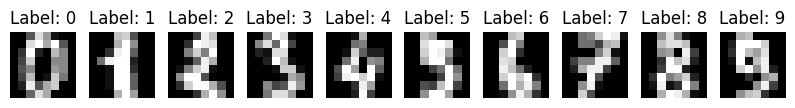

In [24]:
digits = load_digits()

fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {digits.target[i]}')

plt.show()

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [25]:
X, y = digits.data, digits.target

In [27]:
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'BaggingClassifier (100 trees)': BaggingClassifier(n_estimators=100, random_state=42),
    'BaggingClassifier (max_features=sqrt(N))': BaggingClassifier(n_estimators=100, max_features=int(np.sqrt(X.shape[1])), random_state=42),
    'BaggingClassifier (max_features at split)': BaggingClassifier(n_estimators=100, max_features=int(np.sqrt(X.shape[1])), bootstrap_features=True, random_state=42),
    'RandomForestClassifier (100 trees)': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    print(f'{name}: {np.mean(scores):.4f}')

DecisionTreeClassifier: 0.8336
BaggingClassifier (100 trees): 0.9271
BaggingClassifier (max_features=sqrt(N)): 0.9299
BaggingClassifier (max_features at split): 0.9260
RandomForestClassifier (100 trees): 0.9494


### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

Магия заключается в том, что в первом случае (ограничение на количество признаков при разбиении) уменьшается корреляция между деревьями, создаются более разнообразные и независимые модели, в то время как во втором случае (ограничение признаков для всего дерева) получаются более сильные, но менее разнообразные деревья, которые ещё и могут переобучиться

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [28]:
n_trees_values = [1, 5, 10, 15, 50, 100, 150, 200, 300]

mean_scores = []

# Перебор количества деревьев
for n_trees in n_trees_values:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    scores = cross_val_score(rf, X, y, cv=10, scoring='accuracy')
    mean_scores.append(np.mean(scores))

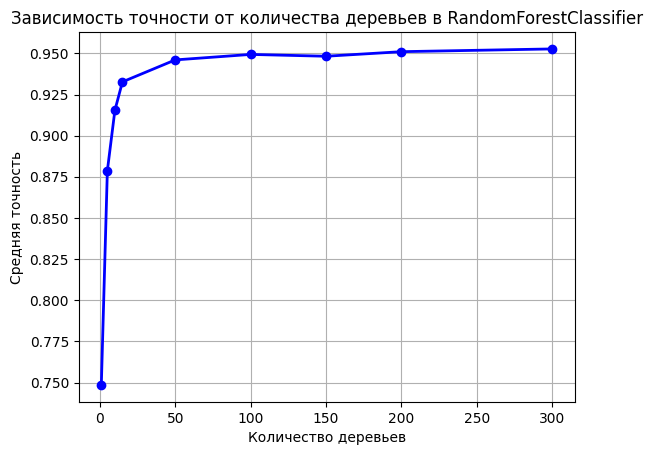

Лучшее качество при количестве деревьев: 300 с точностью 0.9527


In [29]:
plt.plot(n_trees_values, mean_scores, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Количество деревьев')
plt.ylabel('Средняя точность')
plt.title('Зависимость точности от количества деревьев в RandomForestClassifier')
plt.grid(True)
plt.show()

best_n_trees = n_trees_values[np.argmax(mean_scores)]
print(f'Лучшее качество при количестве деревьев: {best_n_trees} с точностью {max(mean_scores):.4f}')

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

In [31]:
max_features_values = list(range(1, 64, 5))

mean_scores = []

for max_features in max_features_values:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    scores = cross_val_score(rf, X, y, cv=10, scoring='accuracy')
    mean_scores.append(np.mean(scores))


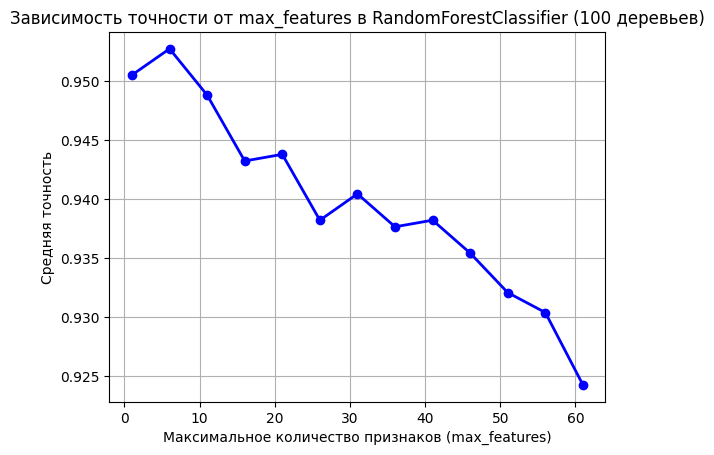

Лучшее качество при max_features = 6 с точностью 0.9527


In [32]:
plt.plot(max_features_values, mean_scores, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Максимальное количество признаков (max_features)')
plt.ylabel('Средняя точность')
plt.title('Зависимость точности от max_features в RandomForestClassifier (100 деревьев)')
plt.grid(True)
plt.show()

best_max_features = max_features_values[np.argmax(mean_scores)]
print(f'Лучшее качество при max_features = {best_max_features} с точностью {max(mean_scores):.4f}')

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

1) С увеличением числа деревьев качество обычно улучшается, но с некоторого момента прирост качества становится минимален, а затраты ресурсов растут. Брать 5000 деревьев не оправдано из-за высоких вычислительных затрат, кроме того, число 42 куда как более красивое

2) Чем меньше max_features, тем деревья разнообразнее, но могут переобучаться на отдельных признаках. Чем больше max_features, тем более схожи деревья, что тоже снижает качество.

3) max_features управляет разнообразием деревьев. Меньше признаков — больше случайности 

4) Глубина деревьев влияет на способность модели обучаться на сложных зависимостях. Малая глубина может привести к недообучению, слишком большая глубина — к переобучению (слишком сложные правила, которые плохо обобщаются)

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)